In [1]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

In [3]:
parall_qubits = [ [ (0,1), (3,5) ],
                    [ (0,1) ],
                    [ (3,5) ]
                ]

qndmt = device_process_measurement_tomography( backend, parall_qubits=parall_qubits )
circuits_qndmt = qndmt.circuits()

In [4]:
job_ids = [
    '7364c64cb08643c8b7a331db8760be76-16638006144369087',
'a317d2f4d40e4138a90e3d867f81aead-16638008680736837',
'5561e4224aee40b3b5b4589851fa1ade-16638008773492372',
'798207b0a1b44a32b79cc4dc3ee95aec-16638008859225643',
'f548a504154e412c8b8def1e60e8e5a7-16638008944027708'
]

In [5]:
results_tomo = []

for job_str in job_ids:
    job = job_manager.retrieve_job_set( job_str, provider )
    result_qiskit = job.results().combine_results()
    result_tomo  = qndmt.fit( result_qiskit, paralell=True, gate_set=True ) 
    results_tomo.append( result_tomo )

In [7]:
quantities_2_mc = []
cros_quantities_mc = []

for k in range(5):

    choi_single = results_tomo[k].single.chois
    povm_single = results_tomo[k].single.povms
    choi_double = [ results_tomo[k].double[j].chois for j in range(3) ]
    povm_double = [ results_tomo[k].double[j].povms for j in range(3) ]

    quantities_2 = []
    cros_quantities = []
    for i in range(len(parall_qubits)):
        for j in range(len(parall_qubits[i])):
            k = parall_qubits[i][j][0]
            l = parall_qubits[i][j][1]
            cros_quantities.append( Cross_Quantities( povm_single[k], choi_single[k],
                                                    povm_single[l], choi_single[l],
                                                    povm_double[i][j], choi_double[i][j]
                                                    )  )
            quantities_2.append( Quantities( povm_double[i][j], choi_double[i][j] ) )

    quantities_2_mc.append( quantities_2 )
    cros_quantities_mc.append( cros_quantities )

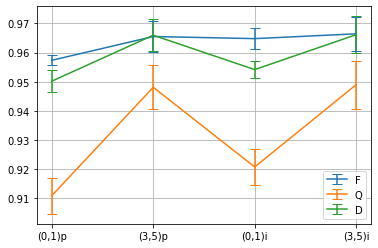

In [8]:
for j in range(3):
    plt.errorbar( [0,1,2,3], np.mean( quantities_2_mc, 0 )[:,j], yerr=np.std( quantities_2_mc, axis=0 )[:,j], capsize=5 )
plt.xticks( [0,1,2,3], labels=[ '(0,1)p', '(3,5)p', '(0,1)i', '(3,5)i'  ]   )
plt.grid()
plt.legend( ['F','Q', 'D'] )

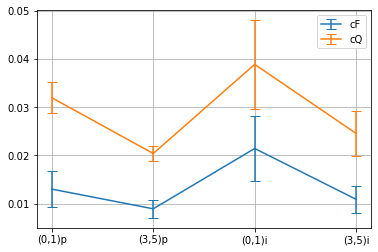

In [9]:
for j in range(2):
    plt.errorbar( [0,1,2,3], np.mean( cros_quantities_mc, 0 )[:,j], yerr=np.std( cros_quantities_mc, axis=0 )[:,j], capsize=5 )
plt.xticks( [0,1,2,3], labels=[ '(0,1)p', '(3,5)p', '(0,1)i', '(3,5)i'  ]   )
plt.legend( ['cF','cQ'] )
plt.grid()